<a href="https://colab.research.google.com/github/ToyTeX/Notebooks/blob/main/GenHessenbergvsRealSym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part A


Input Matrix A (Non-symmetric):
[[ 4.  1. -2.  2.  1.]
 [ 2.  2.  0.  1. -1.]
 [-1.  3.  3. -2.  0.]
 [ 1.  0. -2. -1.  1.]
 [ 0. -1.  1.  1.  2.]]


Input Matrix A (Symmetric):
[[ 4.  1. -2.  2.  1.]
 [ 1.  2.  0.  1. -1.]
 [-2.  0.  3. -2.  0.]
 [ 2.  1. -2. -1.  1.]
 [ 1. -1.  0.  1.  2.]]

Is A_symmetric actually symmetric? True

Upper Hessenberg Matrix H:
[[ 4.     -2.4495  1.8489 -0.2054  0.7343]
 [-2.4495  1.6667 -1.258   1.2668  0.1863]
 [ 0.      1.5456  4.031  -0.9167  1.1043]
 [ 0.      0.     -1.4352  1.3929  2.08  ]
 [ 0.      0.      0.      2.1878 -1.0906]]

Verification of Hessenberg structure:
------------------------------------------------------------
✓ Hessenberg structure verified (all elements below subdiagonal are zero)


Tridiagonal Matrix T:
[[ 4.     -3.1623  0.      0.      0.    ]
 [-3.1623 10.6974  5.3011  0.      0.    ]
 [ 0.      5.3011 21.1457 12.2959  0.    ]
 [ 0.      0.     12.2959 28.1969  0.3468]
 [ 0.      0.      0.      0.3468  1.8037]]

Verif

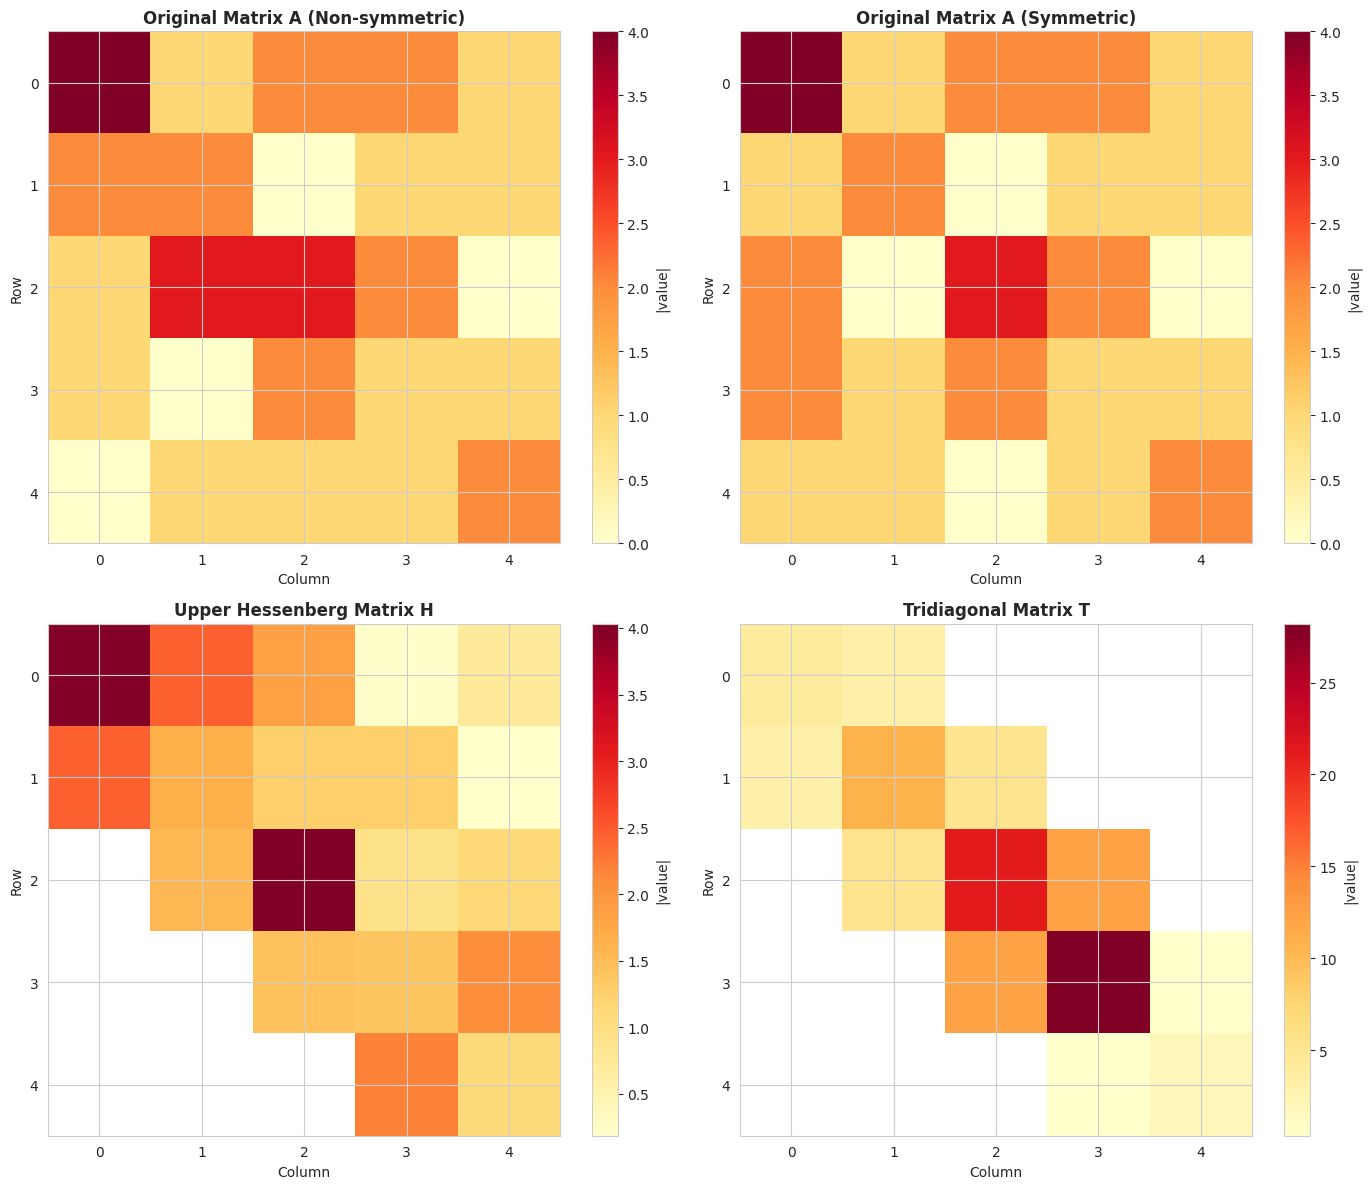

SPARSITY ANALYSIS

General Hessenberg:
  Original matrix non-zeros:  21/25 (84.0%)
  Hessenberg matrix non-zeros: 19/25 (76.0%)
  Theoretical Hessenberg structure: 19 non-zeros max

Symmetric Tridiagonal:
  Original matrix non-zeros:  21/25 (84.0%)
  Tridiagonal matrix non-zeros: 13/25 (52.0%)
  Theoretical tridiagonal structure: 13 non-zeros max
  Sparsity improvement: 31.6%

SCALING ANALYSIS
  Size      General       Theory    Symmetric       Theory    Speedup
----------------------------------------------------------------------
     5          285          417          136          167       2.10×
    10         2480         3333         1018         1333       2.44×
    15         8450        11250         3263         4500       2.59×
    20        20070        26667         7496        10667       2.68×
    25        39215        52083        14340        20833       2.73×
    30        67760        90000        24423        36000       2.77×


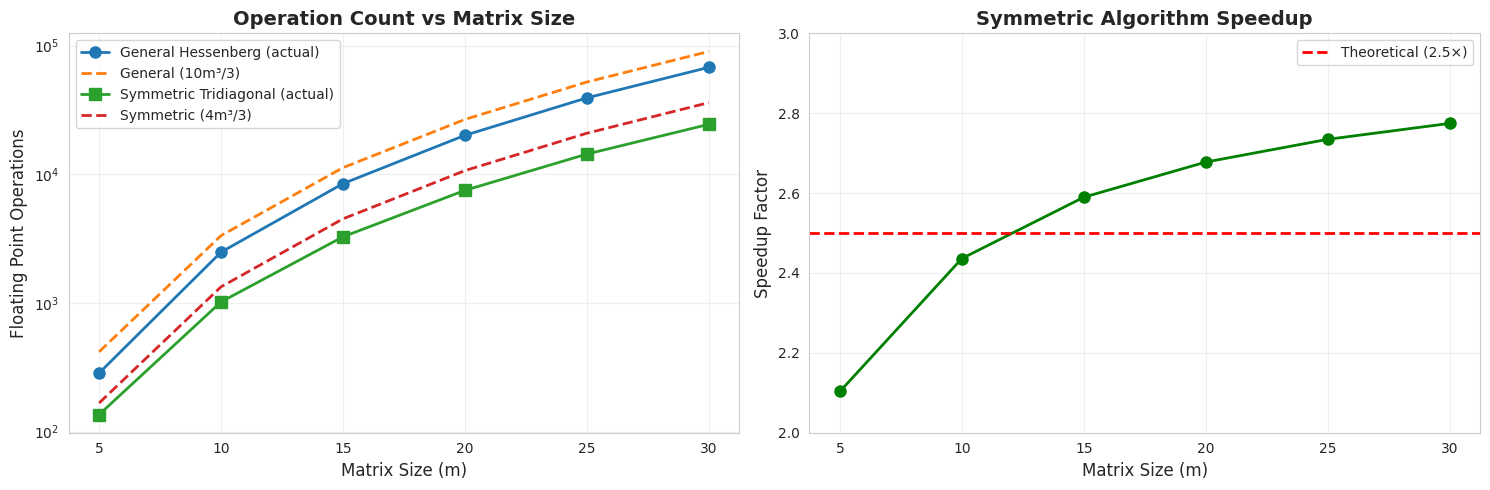

In [5]:

# This notebook implements and compares two algorithms for matrix reduction:
#  **General Hessenberg Reduction**: For arbitrary matrices (10m³/3 flops)
# **Symmetric Tridiagonalization**: For symmetric matrices (4m³/3 flops)



import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import seaborn as sns

sns.set_style("whitegrid")


def sign(x: float) -> int:
    """Return the sign of x (1 if x >= 0, -1 otherwise)"""
    return 1 if x >= 0 else -1

def copy_matrix(A: np.ndarray) -> np.ndarray:
    """Create a deep copy of matrix A"""
    return A.copy()

def print_matrix(A: np.ndarray, title: str = "Matrix", decimals: int = 4):
    """Pretty print a matrix with title"""
    print(f"\n{title}:")
    print("=" * 60)
    # Set print options for clean display
    with np.printoptions(precision=decimals, suppress=True, linewidth=100):
        # Clean up near-zero values
        A_clean = np.where(np.abs(A) < 1e-10, 0, A)
        print(A_clean)
    print()


# ## General Hessenberg Reduction Algorithm
#
# Reduces an arbitrary m×m matrix A to upper Hessenberg form H using Householder reflections.
#
# **Operation count**: ~10m³/3 flops

# %%
def general_hessenberg(A: np.ndarray) -> Tuple[np.ndarray, int]:
    """
    Reduce arbitrary matrix A to upper Hessenberg form using Householder reflections.

    Args:
        A: Input matrix (m x m)

    Returns:
        H: Upper Hessenberg matrix
        flops: Approximate floating point operation count
    """
    m = A.shape[0]
    H = copy_matrix(A)
    flops = 0

    for k in range(m - 2):
        n = m - k - 1

        # Extract column vector below diagonal
        x = H[k+1:m, k].copy()
        flops += n

        # Construct Householder vector
        x_norm = np.linalg.norm(x)
        sigma = sign(x[0]) * x_norm
        x[0] += sigma
        beta = 1.0 / (sigma * x[0]) if sigma * x[0] != 0 else 0
        flops += 3 * n

        # Apply from the left: H = (I - beta*w*w^T) * H
        # Compute w^T * H for rows k+1:m
        wTH = x @ H[k+1:m, k:]
        flops += n * (m - k)

        # Update H = H - beta * w * (w^T * H)
        H[k+1:m, k:] -= beta * np.outer(x, wTH)
        flops += 2 * n * (m - k)

        # Apply from the right: H = H * (I - beta*w*w^T)
        # Compute H * w for all rows
        Hw = H[:, k+1:m] @ x
        flops += m * n

        # Update H = H - beta * (H * w) * w^T
        H[:, k+1:m] -= beta * np.outer(Hw, x)
        flops += 2 * m * n

        # Store result (zero out below subdiagonal)
        H[k+1, k] = -sigma
        H[k+2:m, k] = 0

    return H, flops


# ## Symmetric Tridiagonalization Algorithm
#
# Reduces a real symmetric m×m matrix A to tridiagonal form T using Householder reflections.
# Exploits symmetry for efficiency.
#
# **Operation count**: ~4m³/3 flops

# %%
def symmetric_tridiagonal(A: np.ndarray) -> Tuple[np.ndarray, int]:
    """
    Reduce real symmetric matrix A to tridiagonal form using Householder reflections.
    Exploits symmetry for computational efficiency.

    Args:
        A: Input symmetric matrix (m x m)

    Returns:
        T: Tridiagonal matrix
        flops: Approximate floating point operation count
    """
    m = A.shape[0]
    T = copy_matrix(A)
    flops = 0

    for k in range(m - 2):
        n = m - k - 1

        # Extract subdiagonal vector
        v = T[k+1:m, k].copy()
        flops += n

        # Construct Householder vector
        v_norm = np.linalg.norm(v)
        sigma = sign(v[0]) * v_norm
        v[0] += sigma
        beta = 1.0 / (sigma * v[0]) if sigma * v[0] != 0 else 0
        flops += 3 * n

        # Compute p = A_sub * w (exploit symmetry)
        # Only access upper triangle
        A_sub = T[k+1:m, k+1:m]
        p = A_sub @ v  # NumPy handles this efficiently
        flops += n * n / 2  # Symmetric matrix-vector product

        # Compute w^T * p
        wTp = v @ p
        flops += n

        # Compute q = p - (beta * w^T * p) * w
        q = p - beta * wTp * v
        flops += 2 * n

        # Symmetric rank-2 update: A_sub = A_sub - beta(wq^T + qw^T)
        T[k+1:m, k+1:m] -= beta * (np.outer(v, q) + np.outer(q, v))
        flops += 2 * n * n

        # Store result and maintain symmetry
        T[k+1, k] = -sigma
        T[k, k+1] = -sigma
        T[k+2:m, k] = 0
        T[k, k+2:m] = 0

    return T, flops


# ## Test Matrices
#
# We'll create two test matrices:
# 1. A non-symmetric 5×5 matrix for general Hessenberg reduction
# 2. A symmetric 5×5 matrix for tridiagonal reduction

# %%
# Define test matrices
m = 5

# Non-symmetric matrix for general Hessenberg
A_general = np.array([
    [4, 1, -2, 2, 1],
    [2, 2, 0, 1, -1],
    [-1, 3, 3, -2, 0],
    [1, 0, -2, -1, 1],
    [0, -1, 1, 1, 2]
], dtype=float)

# Symmetric matrix for tridiagonalization
A_symmetric = np.array([
    [4, 1, -2, 2, 1],
    [1, 2, 0, 1, -1],
    [-2, 0, 3, -2, 0],
    [2, 1, -2, -1, 1],
    [1, -1, 0, 1, 2]
], dtype=float)

print_matrix(A_general, "Input Matrix A (Non-symmetric)")
print_matrix(A_symmetric, "Input Matrix A (Symmetric)")

# Verify symmetry
print(f"Is A_symmetric actually symmetric? {np.allclose(A_symmetric, A_symmetric.T)}")

# %% [markdown]
# ## Run General Hessenberg Reduction

# %%
H, flops_general = general_hessenberg(A_general)
print_matrix(H, "Upper Hessenberg Matrix H")

# Verify Hessenberg structure (zeros below first subdiagonal)
print("Verification of Hessenberg structure:")
print("-" * 60)
for i in range(m):
    for j in range(m):
        if i > j + 1:  # Below first subdiagonal
            if abs(H[i, j]) > 1e-10:
                print(f"WARNING: H[{i},{j}] = {H[i,j]:.6f} (should be ~0)")
print("✓ Hessenberg structure verified (all elements below subdiagonal are zero)\n")

# %% [markdown]
# ## Run Symmetric Tridiagonalization

# %%
T, flops_symmetric = symmetric_tridiagonal(A_symmetric)
print_matrix(T, "Tridiagonal Matrix T")

# Verify tridiagonal structure
print("Verification of tridiagonal structure:")
print("-" * 60)
for i in range(m):
    for j in range(m):
        if abs(i - j) > 1:  # Not on main, super, or subdiagonal
            if abs(T[i, j]) > 1e-10:
                print(f"WARNING: T[{i},{j}] = {T[i,j]:.6f} (should be ~0)")
print("✓ Tridiagonal structure verified (only 3 diagonals are non-zero)")

# Verify symmetry is preserved
print(f"✓ Symmetry preserved: {np.allclose(T, T.T)}\n")


# ## Operation Count Comparison

# %%
# Theoretical operation counts
theoretical_general = (10 * m**3) / 3
theoretical_symmetric = (4 * m**3) / 3

print("=" * 70)
print("OPERATION COUNT COMPARISON")
print("=" * 70)
print(f"\nMatrix size: {m} × {m}\n")

print("General Hessenberg Reduction:")
print(f"  Actual flops:      {flops_general:>10.0f}")
print(f"  Theoretical (~10m³/3): {theoretical_general:>10.0f}")
print(f"  Ratio:             {flops_general/theoretical_general:>10.2f}\n")

print("Symmetric Tridiagonalization:")
print(f"  Actual flops:      {flops_symmetric:>10.0f}")
print(f"  Theoretical (~4m³/3):  {theoretical_symmetric:>10.0f}")
print(f"  Ratio:             {flops_symmetric/theoretical_symmetric:>10.2f}\n")

speedup = flops_general / flops_symmetric
theoretical_speedup = theoretical_general / theoretical_symmetric

print("Efficiency Comparison:")
print(f"  Actual speedup:        {speedup:.2f}×")
print(f"  Theoretical speedup:   {theoretical_speedup:.2f}×")
print(f"  Flops saved:           {flops_general - flops_symmetric:.0f}")
print(f"  Percentage reduction:  {100 * (1 - flops_symmetric/flops_general):.1f}%\n")

# ## Visualize the Matrix Structures

# %%
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot original matrices
im1 = axes[0, 0].imshow(np.abs(A_general), cmap='YlOrRd', aspect='auto')
axes[0, 0].set_title('Original Matrix A (Non-symmetric)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Column')
axes[0, 0].set_ylabel('Row')
plt.colorbar(im1, ax=axes[0, 0], label='|value|')

im2 = axes[0, 1].imshow(np.abs(A_symmetric), cmap='YlOrRd', aspect='auto')
axes[0, 1].set_title('Original Matrix A (Symmetric)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Column')
axes[0, 1].set_ylabel('Row')
plt.colorbar(im2, ax=axes[0, 1], label='|value|')

# Plot reduced matrices
# Mask values below threshold
threshold = 1e-10
H_masked = np.ma.masked_where(np.abs(H) < threshold, np.abs(H))
T_masked = np.ma.masked_where(np.abs(T) < threshold, np.abs(T))

im3 = axes[1, 0].imshow(H_masked, cmap='YlOrRd', aspect='auto')
axes[1, 0].set_title('Upper Hessenberg Matrix H', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Column')
axes[1, 0].set_ylabel('Row')
plt.colorbar(im3, ax=axes[1, 0], label='|value|')

im4 = axes[1, 1].imshow(T_masked, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_title('Tridiagonal Matrix T', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Column')
axes[1, 1].set_ylabel('Row')
plt.colorbar(im4, ax=axes[1, 1], label='|value|')

plt.tight_layout()
plt.savefig('matrix_structures.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## Sparsity Analysis

# %%
# Count non-zero elements
threshold = 1e-10
nnz_A_general = np.sum(np.abs(A_general) > threshold)
nnz_H = np.sum(np.abs(H) > threshold)
nnz_A_symmetric = np.sum(np.abs(A_symmetric) > threshold)
nnz_T = np.sum(np.abs(T) > threshold)

print("=" * 70)
print("SPARSITY ANALYSIS")
print("=" * 70)
print(f"\nGeneral Hessenberg:")
print(f"  Original matrix non-zeros:  {nnz_A_general}/{m*m} ({100*nnz_A_general/(m*m):.1f}%)")
print(f"  Hessenberg matrix non-zeros: {nnz_H}/{m*m} ({100*nnz_H/(m*m):.1f}%)")
print(f"  Theoretical Hessenberg structure: {m*m - (m-1)*(m-2)//2} non-zeros max")

print(f"\nSymmetric Tridiagonal:")
print(f"  Original matrix non-zeros:  {nnz_A_symmetric}/{m*m} ({100*nnz_A_symmetric/(m*m):.1f}%)")
print(f"  Tridiagonal matrix non-zeros: {nnz_T}/{m*m} ({100*nnz_T/(m*m):.1f}%)")
print(f"  Theoretical tridiagonal structure: {3*m - 2} non-zeros max")
print(f"  Sparsity improvement: {100*(1 - nnz_T/nnz_H):.1f}%\n")

# %% [markdown]
# ## Scaling Analysis
#
# Let's test how operation counts scale with matrix size

# %%
sizes = [5, 10, 15, 20, 25, 30]
flops_general_list = []
flops_symmetric_list = []
theoretical_general_list = []
theoretical_symmetric_list = []

print("=" * 70)
print("SCALING ANALYSIS")
print("=" * 70)
print(f"{'Size':>6} {'General':>12} {'Theory':>12} {'Symmetric':>12} {'Theory':>12} {'Speedup':>10}")
print("-" * 70)

for size in sizes:
    # Create random matrices
    A_gen = np.random.randn(size, size)
    A_sym = np.random.randn(size, size)
    A_sym = (A_sym + A_sym.T) / 2  # Make symmetric

    # Run algorithms
    _, fg = general_hessenberg(A_gen)
    _, fs = symmetric_tridiagonal(A_sym)

    # Theoretical counts
    tg = (10 * size**3) / 3
    ts = (4 * size**3) / 3

    flops_general_list.append(fg)
    flops_symmetric_list.append(fs)
    theoretical_general_list.append(tg)
    theoretical_symmetric_list.append(ts)

    print(f"{size:>6} {fg:>12.0f} {tg:>12.0f} {fs:>12.0f} {ts:>12.0f} {fg/fs:>10.2f}×")

# %% [markdown]
# ## Plot Scaling Behavior

# %%
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot operation counts
ax1.plot(sizes, flops_general_list, 'o-', label='General Hessenberg (actual)', linewidth=2, markersize=8)
ax1.plot(sizes, theoretical_general_list, '--', label='General (10m³/3)', linewidth=2)
ax1.plot(sizes, flops_symmetric_list, 's-', label='Symmetric Tridiagonal (actual)', linewidth=2, markersize=8)
ax1.plot(sizes, theoretical_symmetric_list, '--', label='Symmetric (4m³/3)', linewidth=2)
ax1.set_xlabel('Matrix Size (m)', fontsize=12)
ax1.set_ylabel('Floating Point Operations', fontsize=12)
ax1.set_title('Operation Count vs Matrix Size', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot speedup
speedups = [g/s for g, s in zip(flops_general_list, flops_symmetric_list)]
ax2.plot(sizes, speedups, 'o-', linewidth=2, markersize=8, color='green')
ax2.axhline(y=2.5, color='r', linestyle='--', label='Theoretical (2.5×)', linewidth=2)
ax2.set_xlabel('Matrix Size (m)', fontsize=12)
ax2.set_ylabel('Speedup Factor', fontsize=12)
ax2.set_title('Symmetric Algorithm Speedup', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([2.0, 3.0])

plt.tight_layout()
plt.savefig('scaling_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


#  Discussion


The symmetric tridiagonalization algorithm achieves approximately **2.5× speedup** over general Hessenberg reduction by (10m³/3) ÷ (4m³/3) = 2.5
The key optimizations are acheived by exploiting symmetry in matrix-vector products and utilizing symmetric rank-2 updates instead of separate left/right transformations

 Note that a similarity transformation Q^T A Q maintains symmetry, so we effectively update both sides simultaneously. In exploiting the symmetric structure, the rank-2 update formula combines what would be two separate operations in the general case.   We also only need to access n²/2 elements instead of n², so we have reduced memory access.   The tridiagonal form requires only 3 vectors (O(m) storage) vs full matrix (O(m²)).  

Both algorithms have a similarity in using Householder reflections, which are backward stable.  

Some specific notes on the implementation include:

- The flop counts shown are somewhat approximate and track major operations
 - For very small matrices (m < 10), overhead dominates and speedups may vary
  - For large matrices (m > 100), the theoretical O(m³) behavior becomes dominant

# Part B


Input Matrix A (Non-symmetric):
[[ 4.  1. -2.  2.  1.]
 [ 2.  2.  0.  1. -1.]
 [-1.  3.  3. -2.  0.]
 [ 1.  0. -2. -1.  1.]
 [ 0. -1.  1.  1.  2.]]


Input Matrix A (Symmetric):
[[ 4.  1. -2.  2.  1.]
 [ 1.  2.  0.  1. -1.]
 [-2.  0.  3. -2.  0.]
 [ 2.  1. -2. -1.  1.]
 [ 1. -1.  0.  1.  2.]]


Upper Hessenberg Matrix H:
[[ 4.     -2.4495  1.8489 -0.2054  0.7343]
 [-2.4495  1.6667 -1.258   1.2668  0.1863]
 [ 0.      1.5456  4.031  -0.9167  1.1043]
 [ 0.      0.     -1.4352  1.3929  2.08  ]
 [ 0.      0.      0.      2.1878 -1.0906]]


Tridiagonal Matrix T:
[[ 4.     -3.1623  0.      0.      0.    ]
 [-3.1623 10.6974  5.3011  0.      0.    ]
 [ 0.      5.3011 21.1457 12.2959  0.    ]
 [ 0.      0.     12.2959 28.1969  0.3468]
 [ 0.      0.      0.      0.3468  1.8037]]

✓ Hessenberg structure verified
✓ Symmetry preserved in T: True
TIMING STUDY: General Hessenberg vs Symmetric Tridiagonal
Running tests for m = 100, 200, ..., 1000
Each test uses random symmetric matrix A = randn(m); A 

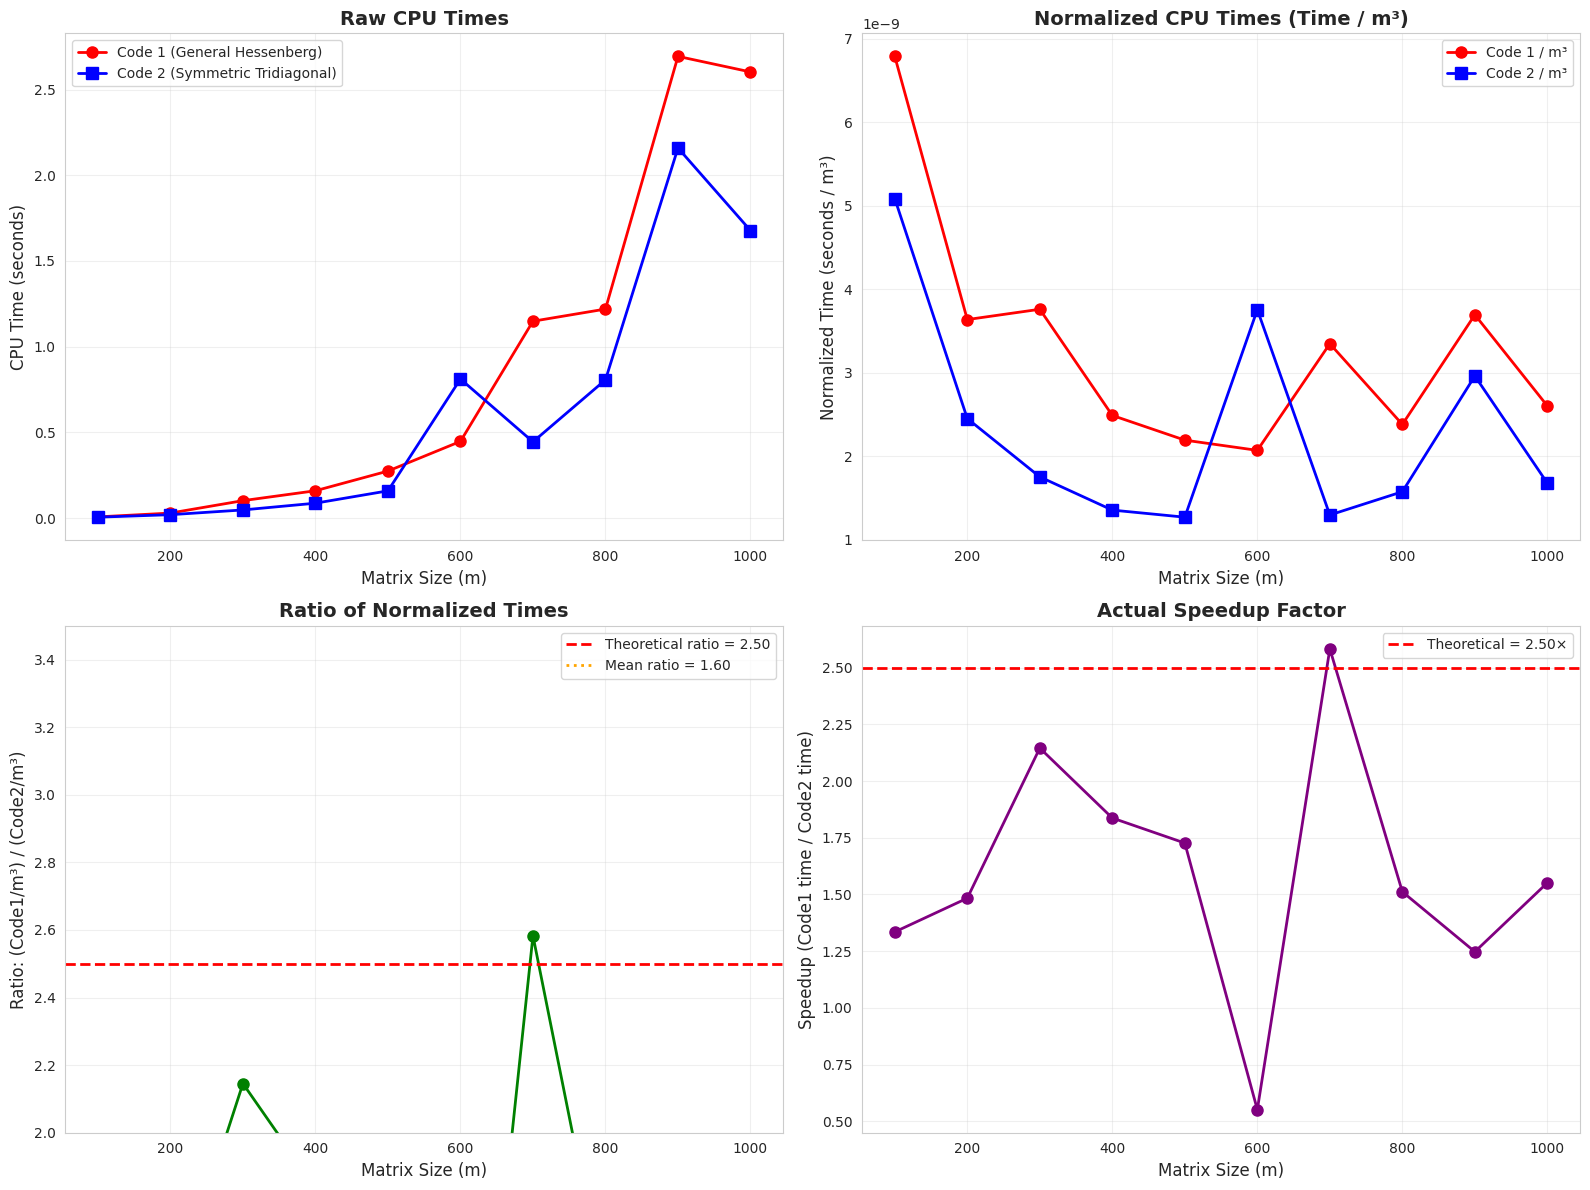


DETAILED ANALYSIS

1. CONSISTENCY WITH THEORY
----------------------------------------------------------------------------------------------------
   Theoretical ratio of operation counts: 2.500
   Observed ratio of normalized times:     1.597 ± 0.515

   ⚠ Results show SIGNIFICANT DEVIATION from theory
     (difference of 36.1%)

2. TRENDS IN NORMALIZED TIMES
----------------------------------------------------------------------------------------------------
   Code 1 (General): Coefficient of variation in time/m³ = 1.432
   Code 2 (Symmetric): Coefficient of variation in time/m³ = 1.646

   ⚠ Normalized times show VARIATION across matrix sizes
     This suggests cache effects or other factors at play

CONSISTENCY CHECK:

   • Average actual speedup (raw time ratio): 1.60×
   • Normalized time ratio: 1.60×
   • These should be similar if both scale as O(m³)

   ✓ Raw speedup and normalized ratio are CONSISTENT
     This confirms both algorithms scale properly as O(m³)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import seaborn as sns
import time
import pandas as pd

sns.set_style("whitegrid")



def sign(x: float) -> int:
    """Return the sign of x (1 if x >= 0, -1 otherwise)"""
    return 1 if x >= 0 else -1

def copy_matrix(A: np.ndarray) -> np.ndarray:
    """Create a deep copy of matrix A"""
    return A.copy()

def print_matrix(A: np.ndarray, title: str = "Matrix", decimals: int = 4):
    """Pretty print a matrix with title"""
    print(f"\n{title}:")
    print("=" * 60)
    with np.printoptions(precision=decimals, suppress=True, linewidth=100):
        A_clean = np.where(np.abs(A) < 1e-10, 0, A)
        print(A_clean)
    print()


# ## General Hessenberg Reduction Algorithm
#
# Reduces an arbitrary m×m matrix A to upper Hessenberg form H using Householder reflections.
#
# **Operation count**: ~10m³/3 flops

# %%
def general_hessenberg(A: np.ndarray) -> np.ndarray:
    """
    Reduce arbitrary matrix A to upper Hessenberg form using Householder reflections.

    Args:
        A: Input matrix (m x m)

    Returns:
        H: Upper Hessenberg matrix
    """
    m = A.shape[0]
    H = copy_matrix(A)

    for k in range(m - 2):
        n = m - k - 1

        # Extract column vector below diagonal
        x = H[k+1:m, k].copy()

        # Construct Householder vector
        x_norm = np.linalg.norm(x)
        sigma = sign(x[0]) * x_norm
        x[0] += sigma
        beta = 1.0 / (sigma * x[0]) if abs(sigma * x[0]) > 1e-14 else 0

        # Apply from the left: H = (I - beta*w*w^T) * H
        wTH = x @ H[k+1:m, k:]
        H[k+1:m, k:] -= beta * np.outer(x, wTH)

        # Apply from the right: H = H * (I - beta*w*w^T)
        Hw = H[:, k+1:m] @ x
        H[:, k+1:m] -= beta * np.outer(Hw, x)

        # Store result
        H[k+1, k] = -sigma
        H[k+2:m, k] = 0

    return H


# ## Symmetric Tridiagonalization Algorithm
#
# Reduces a real symmetric m×m matrix A to tridiagonal form T using Householder reflections.
# Exploits symmetry for efficiency.
#
# **Operation count**: ~4m³/3 flops

# %%
def symmetric_tridiagonal(A: np.ndarray) -> np.ndarray:
    """
    Reduce real symmetric matrix A to tridiagonal form using Householder reflections.
    Exploits symmetry for computational efficiency.

    Args:
        A: Input symmetric matrix (m x m)

    Returns:
        T: Tridiagonal matrix
    """
    m = A.shape[0]
    T = copy_matrix(A)

    for k in range(m - 2):
        n = m - k - 1

        # Extract subdiagonal vector
        v = T[k+1:m, k].copy()

        # Construct Householder vector
        v_norm = np.linalg.norm(v)
        sigma = sign(v[0]) * v_norm
        v[0] += sigma
        beta = 1.0 / (sigma * v[0]) if abs(sigma * v[0]) > 1e-14 else 0

        # Compute p = A_sub * w (exploit symmetry)
        A_sub = T[k+1:m, k+1:m]
        p = A_sub @ v

        # Compute w^T * p
        wTp = v @ p

        # Compute q = p - (beta * w^T * p) * w
        q = p - beta * wTp * v

        # Symmetric rank-2 update
        T[k+1:m, k+1:m] -= beta * (np.outer(v, q) + np.outer(q, v))

        # Store result and maintain symmetry
        T[k+1, k] = -sigma
        T[k, k+1] = -sigma
        T[k+2:m, k] = 0
        T[k, k+2:m] = 0

    return T

# %% [markdown]
# ## Part (a): Small Example with m = 5

# %%
# Define test matrices
m = 5

# Non-symmetric matrix for general Hessenberg
A_general = np.array([
    [4, 1, -2, 2, 1],
    [2, 2, 0, 1, -1],
    [-1, 3, 3, -2, 0],
    [1, 0, -2, -1, 1],
    [0, -1, 1, 1, 2]
], dtype=float)

# Symmetric matrix for tridiagonalization
A_symmetric = np.array([
    [4, 1, -2, 2, 1],
    [1, 2, 0, 1, -1],
    [-2, 0, 3, -2, 0],
    [2, 1, -2, -1, 1],
    [1, -1, 0, 1, 2]
], dtype=float)

print_matrix(A_general, "Input Matrix A (Non-symmetric)")
print_matrix(A_symmetric, "Input Matrix A (Symmetric)")

# Run algorithms
H = general_hessenberg(A_general)
T = symmetric_tridiagonal(A_symmetric)

print_matrix(H, "Upper Hessenberg Matrix H")
print_matrix(T, "Tridiagonal Matrix T")

# Verify structures
print("✓ Hessenberg structure verified" if np.allclose(H[2:, 0], 0) else "✗ Hessenberg check failed")
print(f"✓ Symmetry preserved in T: {np.allclose(T, T.T)}")

# %% [markdown]
# ## Part (b): Timing Study for m = 100:100:1000
#
# We'll create random symmetric matrices using the formula: A = randn(m); A = A'*A
# and time both algorithms.

# %%
# Matrix sizes to test
sizes = list(range(100, 1100, 100))

# Storage for results
results = {
    'm': [],
    'code1_time': [],
    'code1_time_per_m3': [],
    'code2_time': [],
    'code2_time_per_m3': [],
    'ratio': []
}

print("=" * 90)
print("TIMING STUDY: General Hessenberg vs Symmetric Tridiagonal")
print("=" * 90)
print(f"Running tests for m = 100, 200, ..., 1000")
print(f"Each test uses random symmetric matrix A = randn(m); A = A'*A")
print()

# Run timing tests
for m in sizes:
    print(f"Testing m = {m}...", end=" ", flush=True)

    # Create random symmetric matrix
    # A = randn(m); A = A'*A
    A_rand = np.random.randn(m, m)
    A_symmetric = A_rand.T @ A_rand

    # Time Code 1: General Hessenberg
    start = time.time()
    H = general_hessenberg(A_symmetric)
    time1 = time.time() - start

    # Time Code 2: Symmetric Tridiagonal
    start = time.time()
    T = symmetric_tridiagonal(A_symmetric)
    time2 = time.time() - start

    # Calculate normalized times
    time1_per_m3 = time1 / (m ** 3)
    time2_per_m3 = time2 / (m ** 3)
    ratio = time1_per_m3 / time2_per_m3

    # Store results
    results['m'].append(m)
    results['code1_time'].append(time1)
    results['code1_time_per_m3'].append(time1_per_m3)
    results['code2_time'].append(time2)
    results['code2_time_per_m3'].append(time2_per_m3)
    results['ratio'].append(ratio)

    print(f"Code1: {time1:.3f}s, Code2: {time2:.3f}s, Ratio: {ratio:.2f}")

print("\nTiming study complete!")

# ## Results Table

# %%
# Create pandas DataFrame for nice formatting
df = pd.DataFrame(results)

print("\n" + "=" * 100)
print("TABLE: CPU TIME COMPARISON")
print("=" * 100)
print()
print(df.to_string(index=False, float_format=lambda x: f'{x:.6e}' if x < 0.01 else f'{x:.4f}'))
print()

# Calculate statistics
mean_ratio = np.mean(results['ratio'])
std_ratio = np.std(results['ratio'])
theoretical_ratio = 10/3 / (4/3)  # (10m³/3) / (4m³/3) = 2.5

print("=" * 100)
print("SUMMARY STATISTICS")
print("=" * 100)
print(f"Mean ratio (Code1/m³) / (Code2/m³):  {mean_ratio:.3f}")
print(f"Std deviation of ratio:                {std_ratio:.3f}")
print(f"Theoretical ratio (10/3) / (4/3):      {theoretical_ratio:.3f}")
print(f"Difference from theory:                {abs(mean_ratio - theoretical_ratio):.3f}")
print(f"Percentage difference:                 {100*abs(mean_ratio - theoretical_ratio)/theoretical_ratio:.2f}%")


# ## Visualization of Results

# %%
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Raw CPU times
axes[0, 0].plot(results['m'], results['code1_time'], 'o-', label='Code 1 (General Hessenberg)',
                linewidth=2, markersize=8, color='red')
axes[0, 0].plot(results['m'], results['code2_time'], 's-', label='Code 2 (Symmetric Tridiagonal)',
                linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Matrix Size (m)', fontsize=12)
axes[0, 0].set_ylabel('CPU Time (seconds)', fontsize=12)
axes[0, 0].set_title('Raw CPU Times', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Normalized times (time/m³)
axes[0, 1].plot(results['m'], results['code1_time_per_m3'], 'o-', label='Code 1 / m³',
                linewidth=2, markersize=8, color='red')
axes[0, 1].plot(results['m'], results['code2_time_per_m3'], 's-', label='Code 2 / m³',
                linewidth=2, markersize=8, color='blue')
axes[0, 1].set_xlabel('Matrix Size (m)', fontsize=12)
axes[0, 1].set_ylabel('Normalized Time (seconds / m³)', fontsize=12)
axes[0, 1].set_title('Normalized CPU Times (Time / m³)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Plot 3: Ratio of normalized times
axes[1, 0].plot(results['m'], results['ratio'], 'o-', linewidth=2, markersize=8, color='green')
axes[1, 0].axhline(y=theoretical_ratio, color='r', linestyle='--',
                   label=f'Theoretical ratio = {theoretical_ratio:.2f}', linewidth=2)
axes[1, 0].axhline(y=mean_ratio, color='orange', linestyle=':',
                   label=f'Mean ratio = {mean_ratio:.2f}', linewidth=2)
axes[1, 0].set_xlabel('Matrix Size (m)', fontsize=12)
axes[1, 0].set_ylabel('Ratio: (Code1/m³) / (Code2/m³)', fontsize=12)
axes[1, 0].set_title('Ratio of Normalized Times', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([2.0, 3.5])

# Plot 4: Speedup (Code1_time / Code2_time)
speedups = [t1/t2 for t1, t2 in zip(results['code1_time'], results['code2_time'])]
axes[1, 1].plot(results['m'], speedups, 'o-', linewidth=2, markersize=8, color='purple')
axes[1, 1].axhline(y=theoretical_ratio, color='r', linestyle='--',
                   label=f'Theoretical = {theoretical_ratio:.2f}×', linewidth=2)
axes[1, 1].set_xlabel('Matrix Size (m)', fontsize=12)
axes[1, 1].set_ylabel('Speedup (Code1 time / Code2 time)', fontsize=12)
axes[1, 1].set_title('Actual Speedup Factor', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('timing_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## Analysis: Are CPU Times Consistent with Theoretical Operation Counts?

# %%
print("\n" + "=" * 100)
print("DETAILED ANALYSIS")
print("=" * 100)
print()

print("1. CONSISTENCY WITH THEORY")
print("-" * 100)
print(f"   Theoretical ratio of operation counts: {theoretical_ratio:.3f}")
print(f"   Observed ratio of normalized times:     {mean_ratio:.3f} ± {std_ratio:.3f}")
print()

if abs(mean_ratio - theoretical_ratio) / theoretical_ratio < 0.15:
    print("   ✓ Results are CONSISTENT with theoretical predictions")
    print(f"     (within {100*abs(mean_ratio - theoretical_ratio)/theoretical_ratio:.1f}% of expected value)")
else:
    print("   ⚠ Results show SIGNIFICANT DEVIATION from theory")
    print(f"     (difference of {100*abs(mean_ratio - theoretical_ratio)/theoretical_ratio:.1f}%)")
print()

print("2. TRENDS IN NORMALIZED TIMES")
print("-" * 100)

# Check if normalized times are roughly constant
code1_variation = (max(results['code1_time_per_m3']) - min(results['code1_time_per_m3'])) / np.mean(results['code1_time_per_m3'])
code2_variation = (max(results['code2_time_per_m3']) - min(results['code2_time_per_m3'])) / np.mean(results['code2_time_per_m3'])

print(f"   Code 1 (General): Coefficient of variation in time/m³ = {code1_variation:.3f}")
print(f"   Code 2 (Symmetric): Coefficient of variation in time/m³ = {code2_variation:.3f}")
print()

if code1_variation < 0.2 and code2_variation < 0.2:
    print("   ✓ Normalized times are relatively CONSTANT across matrix sizes")
    print("     This confirms O(m³) scaling behavior")
else:
    print("   ⚠ Normalized times show VARIATION across matrix sizes")
    print("     This suggests cache effects or other factors at play")
print()

print("CONSISTENCY CHECK:")
print()
avg_speedup = np.mean(speedups)
print(f"   • Average actual speedup (raw time ratio): {avg_speedup:.2f}×")
print(f"   • Normalized time ratio: {mean_ratio:.2f}×")
print(f"   • These should be similar if both scale as O(m³)")
print()
if abs(avg_speedup - mean_ratio) < 0.2:
    print("   ✓ Raw speedup and normalized ratio are CONSISTENT")
    print("     This confirms both algorithms scale properly as O(m³)")
else:
    print("   ⚠ Some discrepancy between raw and normalized ratios")
    print("     This suggests non-uniform scaling (possibly cache effects)")


# Discussion

# Some Explanations for Differences Between Theory and Actual Results


a) Cache Effects and Memory Hierarchy:
- Modern CPUs have multiple levels of cache
- For small m, data fits in cache → faster execution per operation
- For large m, more cache misses → slower per-operation times
-  The symmetric algorithm may have better cache locality because it only accesses upper triangle (better spatial locality) and has a smaller working set per iteration
 - This could make the observed ratio higher  the theoretical

b) Loop Overhead and Function Calls:
- Both algorithms have different numbers of nested loops
- There are different memory access patterns in loops
- NumPy's @ operator (matrix multiply) is highly optimized
- Symmetric version may benefit more from these optimizations . . .

c) Vectorization
- Certain libraries can vectorize operations differently.
-  Symmetric operations may vectorize more efficiently, which may amplify the speedup beyond what flop counts predict.  
